
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given: input data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Current actions given: indices
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Next states given: next input data
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, actions, next_states, targetQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits: Sqeezed/compressed/represented states into actions size
        return logits

In [8]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(states, actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fuse compressed states (actions fake) with actions (actions real)
        x_fused = tf.concat(axis=1, values=[states, actions]) # NxD: axis1=N, and axis2=D
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [9]:
# D: Descriminator/Reward function
def discriminator(states, actions, next_states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=next_states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=action_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Fused compressed states, actions, and compressed next_states (all three in action size)
        #h3 = tf.layers.dense(inputs=nl2, units=action_size)
        h3_fused = tf.concat(axis=1, values=[states, actions, nl2])
        bn3 = tf.layers.batch_normalization(h3_fused, training=training)        
        nl3 = tf.maximum(alpha * bn3, bn3)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl3, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [10]:
def model_loss(states, actions, next_states, targetQs, # model_input
               state_size, action_size, hidden_size): # model_init
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(indices=actions, depth=action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(states=actions_fake, actions=actions_real, 
                                   state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=actions_fake, actions=actions_real, action_size=action_size,
                                  next_states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=actions_fake, actions=actions_real, action_size=action_size,
                                  next_states=next_states_real, hidden_size=hidden_size, reuse=True)    

    # GAN: Adverserial training - G-learning -  Relavistic GAN
    g_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    g_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.zeros_like(d_logits_real)))
    g_loss = g_loss_real + g_loss_fake
    
    # VAE: Variational AE reconstruction/prediction loss
    loss_reconst = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, labels=next_states_real))
    q_loss += g_loss + loss_reconst 
    g_loss += loss_reconst
    
    # GAN: Adverserial training - D-learning-  Standard GAN
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [11]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [12]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [18]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [19]:
tf.reset_default_graph()

model = QGAN(state_size=state_size, action_size=action_size, hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [20]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [21]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
q_loss_list, g_loss_list, d_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        q_loss, g_loss, d_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                rewards_real_list.append((ep, rewards_real_mean))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Calculating real current reward and next action
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states}
            next_actions_logits, rewards_fake, rewards_real = sess.run([model.actions_logits, 
                                                                        model.rewards_fake, model.rewards_real], 
                                                                       feed_dict)
            #             feed_dict={model.states: next_states}
            #             next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0) # NOTE: action size

            # Bellman equation: Qt = Rt + max(Qt+1)
            #targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            targetQs = rewards_real.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating/training/optimizing the model
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 2.0 Average reward fake: 0.3243364691734314 Average reward real: 0.3240538537502289 Training q_loss: 2.3744 Training g_loss: 2.2163 Training d_loss: 1.5249 Explore P: 0.9998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 22.0 Average reward fake: 0.3873623013496399 Average reward real: 0.3874487578868866 Training q_loss: 2.3916 Training g_loss: 2.1316 Training d_loss: 1.4437 Explore P: 0.9976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 10.0 Average reward fake: 0.4015706777572632 Average reward real: 0.40142369270324707 Training q_loss: 2.4305 Training g_loss: 2.1198 Training d_loss: 1.4317 Explore P: 0.9966


-------------------------------------------------------------------------------
Episode: 24 Total reward: 16.0 Average reward fake: 0.4981527030467987 Average reward real: 0.5000587105751038 Training q_loss: 8.6113 Training g_loss: 2.0800 Training d_loss: 1.3827 Explore P: 0.9475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 24.0 Average reward fake: 0.499988317489624 Average reward real: 0.5014125108718872 Training q_loss: 9.1643 Training g_loss: 2.0782 Training d_loss: 1.3835 Explore P: 0.9452
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 26 Total reward: 24.0 Average reward fake: 0.4995272159576416 Average reward real: 0.5012660026550293 Training q_loss: 8.6433 Training g_loss: 2.0782 Training d_loss: 1.3831 Explore P: 0.943

-------------------------------------------------------------------------------
Episode: 47 Total reward: 10.0 Average reward fake: 0.48555222153663635 Average reward real: 0.483138769865036 Training q_loss: 3.3574 Training g_loss: 2.0797 Training d_loss: 1.3917 Explore P: 0.8952
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 15.0 Average reward fake: 0.5012736916542053 Average reward real: 0.5014663934707642 Training q_loss: 4.5690 Training g_loss: 2.0818 Training d_loss: 1.3859 Explore P: 0.8939
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 49 Total reward: 12.0 Average reward fake: 0.5018617510795593 Average reward real: 0.5033668279647827 Training q_loss: 3.2402 Training g_loss: 2.0806 Training d_loss: 1.3833 Explore P: 0.89

-------------------------------------------------------------------------------
Episode: 70 Total reward: 15.0 Average reward fake: 0.5001274347305298 Average reward real: 0.5001418590545654 Training q_loss: 2.7132 Training g_loss: 2.0767 Training d_loss: 1.3863 Explore P: 0.8559
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 13.0 Average reward fake: 0.5001954436302185 Average reward real: 0.5001981258392334 Training q_loss: 2.4102 Training g_loss: 2.0740 Training d_loss: 1.3863 Explore P: 0.8548
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 17.0 Average reward fake: 0.4998548924922943 Average reward real: 0.4998821020126343 Training q_loss: 2.7755 Training g_loss: 2.0760 Training d_loss: 1.3862 Explore P: 0.85

-------------------------------------------------------------------------------
Episode: 93 Total reward: 16.0 Average reward fake: 0.5001251697540283 Average reward real: 0.5001254677772522 Training q_loss: 3.2953 Training g_loss: 2.0780 Training d_loss: 1.3863 Explore P: 0.8156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 16.0 Average reward fake: 0.50008225440979 Average reward real: 0.5001072883605957 Training q_loss: 3.2420 Training g_loss: 2.0711 Training d_loss: 1.3862 Explore P: 0.8143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 10.0 Average reward fake: 0.4999816119670868 Average reward real: 0.4999990165233612 Training q_loss: 3.4055 Training g_loss: 2.0724 Training d_loss: 1.3863 Explore P: 0.8135

-------------------------------------------------------------------------------
Episode: 116 Total reward: 68.0 Average reward fake: 0.499939888715744 Average reward real: 0.5000201463699341 Training q_loss: 2.4549 Training g_loss: 2.0754 Training d_loss: 1.3861 Explore P: 0.7794
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 14.0 Average reward fake: 0.5000066161155701 Average reward real: 0.5000499486923218 Training q_loss: 4.8981 Training g_loss: 2.0726 Training d_loss: 1.3862 Explore P: 0.7783
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 47.0 Average reward fake: 0.49997952580451965 Average reward real: 0.5000463724136353 Training q_loss: 3.3169 Training g_loss: 2.0793 Training d_loss: 1.3861 Explore P: 0

-------------------------------------------------------------------------------
Episode: 139 Total reward: 33.0 Average reward fake: 0.499908447265625 Average reward real: 0.5000012516975403 Training q_loss: 3.0801 Training g_loss: 2.0707 Training d_loss: 1.3861 Explore P: 0.7381
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 28.0 Average reward fake: 0.4997672140598297 Average reward real: 0.4999854564666748 Training q_loss: 2.4374 Training g_loss: 2.0741 Training d_loss: 1.3859 Explore P: 0.7360
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 20.0 Average reward fake: 0.5000911951065063 Average reward real: 0.5000770688056946 Training q_loss: 2.5575 Training g_loss: 2.0725 Training d_loss: 1.3862 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 162 Total reward: 27.0 Average reward fake: 0.49983519315719604 Average reward real: 0.500033438205719 Training q_loss: 3.2616 Training g_loss: 2.0808 Training d_loss: 1.3858 Explore P: 0.7038
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 9.0 Average reward fake: 0.4999629855155945 Average reward real: 0.5001713037490845 Training q_loss: 2.3833 Training g_loss: 2.0795 Training d_loss: 1.3860 Explore P: 0.7032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 54.0 Average reward fake: 0.49984535574913025 Average reward real: 0.5002083778381348 Training q_loss: 2.7377 Training g_loss: 2.0784 Training d_loss: 1.3857 Explore P: 0

-------------------------------------------------------------------------------
Episode: 185 Total reward: 17.0 Average reward fake: 0.5000325441360474 Average reward real: 0.5006486773490906 Training q_loss: 6.3438 Training g_loss: 2.0739 Training d_loss: 1.3852 Explore P: 0.6647
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 17.0 Average reward fake: 0.4998266100883484 Average reward real: 0.5002802014350891 Training q_loss: 3.3649 Training g_loss: 2.0751 Training d_loss: 1.3855 Explore P: 0.6635
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 187 Total reward: 13.0 Average reward fake: 0.4998701810836792 Average reward real: 0.5007414221763611 Training q_loss: 3.7850 Training g_loss: 2.0724 Training d_loss: 1.3846 Explore P: 0

-------------------------------------------------------------------------------
Episode: 208 Total reward: 18.0 Average reward fake: 0.49870750308036804 Average reward real: 0.4995986223220825 Training q_loss: 2.3725 Training g_loss: 2.0780 Training d_loss: 1.3855 Explore P: 0.6288
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 21.0 Average reward fake: 0.4998716115951538 Average reward real: 0.5011509656906128 Training q_loss: 2.8719 Training g_loss: 2.0657 Training d_loss: 1.3839 Explore P: 0.6275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 20.0 Average reward fake: 0.5007669925689697 Average reward real: 0.500495195388794 Training q_loss: 2.5216 Training g_loss: 2.0680 Training d_loss: 1.3873 Explore P: 0

-------------------------------------------------------------------------------
Episode: 231 Total reward: 20.0 Average reward fake: 0.49964383244514465 Average reward real: 0.500049352645874 Training q_loss: 2.4029 Training g_loss: 2.0680 Training d_loss: 1.3851 Explore P: 0.5870
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 13.0 Average reward fake: 0.4993089735507965 Average reward real: 0.49946776032447815 Training q_loss: 2.5201 Training g_loss: 2.0675 Training d_loss: 1.3858 Explore P: 0.5862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 130.0 Average reward fake: 0.49990764260292053 Average reward real: 0.5002503991127014 Training q_loss: 2.6674 Training g_loss: 2.0658 Training d_loss: 1.3856 Explore P

-------------------------------------------------------------------------------
Episode: 254 Total reward: 15.0 Average reward fake: 0.4988235533237457 Average reward real: 0.5005698204040527 Training q_loss: 3.4036 Training g_loss: 2.0781 Training d_loss: 1.3833 Explore P: 0.5410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 25.0 Average reward fake: 0.4995717704296112 Average reward real: 0.4988802671432495 Training q_loss: 2.2300 Training g_loss: 2.0698 Training d_loss: 1.3882 Explore P: 0.5396
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 55.0 Average reward fake: 0.4996929466724396 Average reward real: 0.5004415512084961 Training q_loss: 2.6652 Training g_loss: 2.0739 Training d_loss: 1.3847 Explore P: 0

-------------------------------------------------------------------------------
Episode: 277 Total reward: 50.0 Average reward fake: 0.4995190501213074 Average reward real: 0.49914494156837463 Training q_loss: 2.4089 Training g_loss: 2.0730 Training d_loss: 1.3873 Explore P: 0.4825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 31.0 Average reward fake: 0.49983498454093933 Average reward real: 0.500050961971283 Training q_loss: 2.9723 Training g_loss: 2.0708 Training d_loss: 1.3861 Explore P: 0.4810
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 19.0 Average reward fake: 0.5007495880126953 Average reward real: 0.50095534324646 Training q_loss: 3.6132 Training g_loss: 2.0697 Training d_loss: 1.3858 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 300 Total reward: 66.0 Average reward fake: 0.4997138977050781 Average reward real: 0.49996238946914673 Training q_loss: 3.7139 Training g_loss: 2.0692 Training d_loss: 1.3858 Explore P: 0.4324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 19.0 Average reward fake: 0.5002098083496094 Average reward real: 0.5004176497459412 Training q_loss: 2.4012 Training g_loss: 2.0705 Training d_loss: 1.3860 Explore P: 0.4316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 19.0 Average reward fake: 0.5005610585212708 Average reward real: 0.5007873773574829 Training q_loss: 2.2754 Training g_loss: 2.0719 Training d_loss: 1.3860 Explore P: 

-------------------------------------------------------------------------------
Episode: 323 Total reward: 24.0 Average reward fake: 0.499961256980896 Average reward real: 0.5006841421127319 Training q_loss: 2.2937 Training g_loss: 2.0685 Training d_loss: 1.3851 Explore P: 0.3885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 33.0 Average reward fake: 0.5003474950790405 Average reward real: 0.5000870227813721 Training q_loss: 2.3164 Training g_loss: 2.0675 Training d_loss: 1.3873 Explore P: 0.3873
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 51.0 Average reward fake: 0.4999711513519287 Average reward real: 0.50059574842453 Training q_loss: 2.2013 Training g_loss: 2.0688 Training d_loss: 1.3851 Explore P: 0.38

-------------------------------------------------------------------------------
Episode: 346 Total reward: 48.0 Average reward fake: 0.5005244612693787 Average reward real: 0.5005133152008057 Training q_loss: 2.2029 Training g_loss: 2.0718 Training d_loss: 1.3864 Explore P: 0.3399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 98.0 Average reward fake: 0.49984124302864075 Average reward real: 0.49980244040489197 Training q_loss: 2.4182 Training g_loss: 2.0709 Training d_loss: 1.3865 Explore P: 0.3367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 106.0 Average reward fake: 0.49992653727531433 Average reward real: 0.5002903938293457 Training q_loss: 2.5839 Training g_loss: 2.0710 Training d_loss: 1.3858 Explore 

-------------------------------------------------------------------------------
Episode: 369 Total reward: 72.0 Average reward fake: 0.5002702474594116 Average reward real: 0.5004695653915405 Training q_loss: 3.0606 Training g_loss: 2.0728 Training d_loss: 1.3860 Explore P: 0.2913
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 74.0 Average reward fake: 0.49955472350120544 Average reward real: 0.4994962811470032 Training q_loss: 2.8283 Training g_loss: 2.0743 Training d_loss: 1.3864 Explore P: 0.2892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 72.0 Average reward fake: 0.4989783465862274 Average reward real: 0.49937233328819275 Training q_loss: 2.2560 Training g_loss: 2.0719 Training d_loss: 1.3858 Explore P:

-------------------------------------------------------------------------------
Episode: 392 Total reward: 31.0 Average reward fake: 0.5000399947166443 Average reward real: 0.5000059008598328 Training q_loss: 2.1819 Training g_loss: 2.0698 Training d_loss: 1.3865 Explore P: 0.2550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 110.0 Average reward fake: 0.49948540329933167 Average reward real: 0.49962592124938965 Training q_loss: 2.1369 Training g_loss: 2.0685 Training d_loss: 1.3860 Explore P: 0.2524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 24.0 Average reward fake: 0.49995505809783936 Average reward real: 0.5001934766769409 Training q_loss: 2.0905 Training g_loss: 2.0692 Training d_loss: 1.3859 Explore 

-------------------------------------------------------------------------------
Episode: 415 Total reward: 32.0 Average reward fake: 0.5003094673156738 Average reward real: 0.5002155303955078 Training q_loss: 2.0828 Training g_loss: 2.0707 Training d_loss: 1.3865 Explore P: 0.2220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 45.0 Average reward fake: 0.5000580549240112 Average reward real: 0.5004462599754333 Training q_loss: 2.1285 Training g_loss: 2.0701 Training d_loss: 1.3857 Explore P: 0.2211
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 56.0 Average reward fake: 0.4994250237941742 Average reward real: 0.49980345368385315 Training q_loss: 2.2669 Training g_loss: 2.0698 Training d_loss: 1.3856 Explore P: 

-------------------------------------------------------------------------------
Episode: 438 Total reward: 179.0 Average reward fake: 0.50025475025177 Average reward real: 0.500156581401825 Training q_loss: 2.3847 Training g_loss: 2.0738 Training d_loss: 1.3863 Explore P: 0.1912
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 439 Total reward: 49.0 Average reward fake: 0.5004897117614746 Average reward real: 0.5004123449325562 Training q_loss: 2.0955 Training g_loss: 2.0697 Training d_loss: 1.3864 Explore P: 0.1904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 76.0 Average reward fake: 0.4999012351036072 Average reward real: 0.4996742308139801 Training q_loss: 2.1003 Training g_loss: 2.0704 Training d_loss: 1.3870 Explore P: 0.1

-------------------------------------------------------------------------------
Episode: 461 Total reward: 81.0 Average reward fake: 0.49985045194625854 Average reward real: 0.5005519390106201 Training q_loss: 2.1466 Training g_loss: 2.0736 Training d_loss: 1.3848 Explore P: 0.1669
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 462 Total reward: 117.0 Average reward fake: 0.5019736289978027 Average reward real: 0.49658238887786865 Training q_loss: 2.1629 Training g_loss: 2.0633 Training d_loss: 1.3990 Explore P: 0.1651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 63.0 Average reward fake: 0.5004656314849854 Average reward real: 0.49974116683006287 Training q_loss: 2.1180 Training g_loss: 2.0721 Training d_loss: 1.3873 Explore 

-------------------------------------------------------------------------------
Episode: 484 Total reward: 108.0 Average reward fake: 0.49986809492111206 Average reward real: 0.4999312460422516 Training q_loss: 2.1384 Training g_loss: 2.0739 Training d_loss: 1.3862 Explore P: 0.1437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 111.0 Average reward fake: 0.5002259612083435 Average reward real: 0.5003914833068848 Training q_loss: 2.0860 Training g_loss: 2.0695 Training d_loss: 1.3859 Explore P: 0.1422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 67.0 Average reward fake: 0.5000417828559875 Average reward real: 0.49948403239250183 Training q_loss: 2.1202 Training g_loss: 2.0719 Training d_loss: 1.3884 Explore 

-------------------------------------------------------------------------------
Episode: 507 Total reward: 33.0 Average reward fake: 0.4997152090072632 Average reward real: 0.5024790167808533 Training q_loss: 2.1022 Training g_loss: 2.0799 Training d_loss: 1.3818 Explore P: 0.1263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 508 Total reward: 47.0 Average reward fake: 0.5008454322814941 Average reward real: 0.49986517429351807 Training q_loss: 2.1086 Training g_loss: 2.0706 Training d_loss: 1.3873 Explore P: 0.1258
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 132.0 Average reward fake: 0.5005393028259277 Average reward real: 0.50087571144104 Training q_loss: 2.1720 Training g_loss: 2.0714 Training d_loss: 1.3856 Explore P: 0

-------------------------------------------------------------------------------
Episode: 530 Total reward: 79.0 Average reward fake: 0.49988487362861633 Average reward real: 0.49994030594825745 Training q_loss: 2.0799 Training g_loss: 2.0720 Training d_loss: 1.3862 Explore P: 0.1123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 531 Total reward: 27.0 Average reward fake: 0.5000157952308655 Average reward real: 0.499970018863678 Training q_loss: 2.2219 Training g_loss: 2.0721 Training d_loss: 1.3862 Explore P: 0.1121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 81.0 Average reward fake: 0.4997618496417999 Average reward real: 0.4998306334018707 Training q_loss: 2.0966 Training g_loss: 2.0734 Training d_loss: 1.3860 Explore P: 

-------------------------------------------------------------------------------
Episode: 553 Total reward: 37.0 Average reward fake: 0.49980807304382324 Average reward real: 0.4999624192714691 Training q_loss: 2.0776 Training g_loss: 2.0712 Training d_loss: 1.3861 Explore P: 0.1015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 554 Total reward: 85.0 Average reward fake: 0.4996170401573181 Average reward real: 0.49983519315719604 Training q_loss: 2.0874 Training g_loss: 2.0723 Training d_loss: 1.3860 Explore P: 0.1008
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 88.0 Average reward fake: 0.4995051622390747 Average reward real: 0.5001274347305298 Training q_loss: 2.0906 Training g_loss: 2.0728 Training d_loss: 1.3853 Explore P:

-------------------------------------------------------------------------------
Episode: 576 Total reward: 49.0 Average reward fake: 0.4995712339878082 Average reward real: 0.5002859234809875 Training q_loss: 2.0902 Training g_loss: 2.0750 Training d_loss: 1.3847 Explore P: 0.0899
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 577 Total reward: 55.0 Average reward fake: 0.4996076226234436 Average reward real: 0.5001713633537292 Training q_loss: 2.0804 Training g_loss: 2.0719 Training d_loss: 1.3853 Explore P: 0.0895
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 578 Total reward: 62.0 Average reward fake: 0.499235063791275 Average reward real: 0.49985772371292114 Training q_loss: 2.1749 Training g_loss: 2.0740 Training d_loss: 1.3850 Explore P: 0

-------------------------------------------------------------------------------
Episode: 599 Total reward: 49.0 Average reward fake: 0.5004757046699524 Average reward real: 0.5004033446311951 Training q_loss: 2.1120 Training g_loss: 2.0711 Training d_loss: 1.3861 Explore P: 0.0806
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 600 Total reward: 66.0 Average reward fake: 0.4993771016597748 Average reward real: 0.49894779920578003 Training q_loss: 2.0959 Training g_loss: 2.0730 Training d_loss: 1.3874 Explore P: 0.0802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 68.0 Average reward fake: 0.500118613243103 Average reward real: 0.5003293752670288 Training q_loss: 2.0871 Training g_loss: 2.0735 Training d_loss: 1.3858 Explore P: 0

-------------------------------------------------------------------------------
Episode: 622 Total reward: 30.0 Average reward fake: 0.5003421902656555 Average reward real: 0.4993540644645691 Training q_loss: 2.0885 Training g_loss: 2.0686 Training d_loss: 1.3884 Explore P: 0.0723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 97.0 Average reward fake: 0.5004473328590393 Average reward real: 0.4998813569545746 Training q_loss: 2.0805 Training g_loss: 2.0746 Training d_loss: 1.3861 Explore P: 0.0717
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 92.0 Average reward fake: 0.4999074637889862 Average reward real: 0.49953407049179077 Training q_loss: 2.0767 Training g_loss: 2.0719 Training d_loss: 1.3866 Explore P: 

-------------------------------------------------------------------------------
Episode: 645 Total reward: 21.0 Average reward fake: 0.5085817575454712 Average reward real: 0.4924362897872925 Training q_loss: 2.0724 Training g_loss: 2.0611 Training d_loss: 1.4156 Explore P: 0.0651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 646 Total reward: 151.0 Average reward fake: 0.49993306398391724 Average reward real: 0.5000171661376953 Training q_loss: 2.0954 Training g_loss: 2.0738 Training d_loss: 1.3862 Explore P: 0.0643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 647 Total reward: 60.0 Average reward fake: 0.5000572204589844 Average reward real: 0.4999419152736664 Training q_loss: 2.0839 Training g_loss: 2.0718 Training d_loss: 1.3865 Explore P:

-------------------------------------------------------------------------------
Episode: 668 Total reward: 60.0 Average reward fake: 0.49982574582099915 Average reward real: 0.5001991987228394 Training q_loss: 2.0837 Training g_loss: 2.0725 Training d_loss: 1.3854 Explore P: 0.0558
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 88.0 Average reward fake: 0.4998738169670105 Average reward real: 0.5004079341888428 Training q_loss: 2.1007 Training g_loss: 2.0728 Training d_loss: 1.3852 Explore P: 0.0554
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 88.0 Average reward fake: 0.49989551305770874 Average reward real: 0.5003747344017029 Training q_loss: 2.0943 Training g_loss: 2.0742 Training d_loss: 1.3854 Explore P:

-------------------------------------------------------------------------------
Episode: 691 Total reward: 65.0 Average reward fake: 0.49990546703338623 Average reward real: 0.49993476271629333 Training q_loss: 2.0809 Training g_loss: 2.0762 Training d_loss: 1.3862 Explore P: 0.0509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 692 Total reward: 50.0 Average reward fake: 0.4999653697013855 Average reward real: 0.4999787211418152 Training q_loss: 2.0794 Training g_loss: 2.0711 Training d_loss: 1.3863 Explore P: 0.0507
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 48.0 Average reward fake: 0.4997742772102356 Average reward real: 0.4998629093170166 Training q_loss: 2.0819 Training g_loss: 2.0742 Training d_loss: 1.3861 Explore P:

-------------------------------------------------------------------------------
Episode: 714 Total reward: 33.0 Average reward fake: 0.500470757484436 Average reward real: 0.4998205602169037 Training q_loss: 2.0783 Training g_loss: 2.0744 Training d_loss: 1.3874 Explore P: 0.0455
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 715 Total reward: 33.0 Average reward fake: 0.4997498393058777 Average reward real: 0.5002803206443787 Training q_loss: 2.1790 Training g_loss: 2.0741 Training d_loss: 1.3852 Explore P: 0.0454
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 716 Total reward: 78.0 Average reward fake: 0.5020349025726318 Average reward real: 0.4986746907234192 Training q_loss: 2.0768 Training g_loss: 2.0723 Training d_loss: 1.3917 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 737 Total reward: 65.0 Average reward fake: 0.4992837905883789 Average reward real: 0.5004818439483643 Training q_loss: 2.0785 Training g_loss: 2.0742 Training d_loss: 1.3844 Explore P: 0.0418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 738 Total reward: 30.0 Average reward fake: 0.5015665292739868 Average reward real: 0.4970470368862152 Training q_loss: 2.1262 Training g_loss: 2.0767 Training d_loss: 1.3950 Explore P: 0.0417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 20.0 Average reward fake: 0.49945881962776184 Average reward real: 0.5007324814796448 Training q_loss: 2.2166 Training g_loss: 2.0745 Training d_loss: 1.3841 Explore P: 

-------------------------------------------------------------------------------
Episode: 760 Total reward: 13.0 Average reward fake: 0.5006279349327087 Average reward real: 0.4987463057041168 Training q_loss: 2.0793 Training g_loss: 2.0739 Training d_loss: 1.3901 Explore P: 0.0385
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 761 Total reward: 33.0 Average reward fake: 0.4999965727329254 Average reward real: 0.4998299777507782 Training q_loss: 2.0834 Training g_loss: 2.0715 Training d_loss: 1.3865 Explore P: 0.0384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 33.0 Average reward fake: 0.5001163482666016 Average reward real: 0.5000514388084412 Training q_loss: 2.0786 Training g_loss: 2.0721 Training d_loss: 1.3864 Explore P: 0

-------------------------------------------------------------------------------
Episode: 783 Total reward: 30.0 Average reward fake: 0.5021977424621582 Average reward real: 0.49826475977897644 Training q_loss: 2.0753 Training g_loss: 2.0718 Training d_loss: 1.3952 Explore P: 0.0353
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 784 Total reward: 39.0 Average reward fake: 0.4999099671840668 Average reward real: 0.4997420608997345 Training q_loss: 2.0825 Training g_loss: 2.0727 Training d_loss: 1.3866 Explore P: 0.0352
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 785 Total reward: 42.0 Average reward fake: 0.500026524066925 Average reward real: 0.49993109703063965 Training q_loss: 2.1029 Training g_loss: 2.0725 Training d_loss: 1.3864 Explore P: 

-------------------------------------------------------------------------------
Episode: 806 Total reward: 52.0 Average reward fake: 0.4999638795852661 Average reward real: 0.4999948740005493 Training q_loss: 2.1355 Training g_loss: 2.0739 Training d_loss: 1.3862 Explore P: 0.0322
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 807 Total reward: 74.0 Average reward fake: 0.49999862909317017 Average reward real: 0.5000320672988892 Training q_loss: 2.0771 Training g_loss: 2.0726 Training d_loss: 1.3862 Explore P: 0.0320
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 808 Total reward: 45.0 Average reward fake: 0.49990004301071167 Average reward real: 0.5000295042991638 Training q_loss: 2.0723 Training g_loss: 2.0706 Training d_loss: 1.3860 Explore P:

-------------------------------------------------------------------------------
Episode: 829 Total reward: 45.0 Average reward fake: 0.49988165497779846 Average reward real: 0.4985927641391754 Training q_loss: 2.1815 Training g_loss: 2.0745 Training d_loss: 1.3891 Explore P: 0.0291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 830 Total reward: 68.0 Average reward fake: 0.5000998973846436 Average reward real: 0.5005365610122681 Training q_loss: 2.0752 Training g_loss: 2.0727 Training d_loss: 1.3854 Explore P: 0.0289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 37.0 Average reward fake: 0.500293493270874 Average reward real: 0.499786913394928 Training q_loss: 2.0774 Training g_loss: 2.0706 Training d_loss: 1.3868 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 852 Total reward: 30.0 Average reward fake: 0.49977225065231323 Average reward real: 0.4997488260269165 Training q_loss: 2.0844 Training g_loss: 2.0760 Training d_loss: 1.3870 Explore P: 0.0270
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 853 Total reward: 34.0 Average reward fake: 0.5001609325408936 Average reward real: 0.49996596574783325 Training q_loss: 2.0804 Training g_loss: 2.0771 Training d_loss: 1.3878 Explore P: 0.0270
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 854 Total reward: 68.0 Average reward fake: 0.5000552535057068 Average reward real: 0.49986740946769714 Training q_loss: 2.0800 Training g_loss: 2.0717 Training d_loss: 1.3868 Explore P

-------------------------------------------------------------------------------
Episode: 875 Total reward: 43.0 Average reward fake: 0.5001389980316162 Average reward real: 0.499647855758667 Training q_loss: 2.0862 Training g_loss: 2.0725 Training d_loss: 1.3874 Explore P: 0.0254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 876 Total reward: 25.0 Average reward fake: 0.5002896785736084 Average reward real: 0.5000783801078796 Training q_loss: 2.0889 Training g_loss: 2.0746 Training d_loss: 1.3869 Explore P: 0.0254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 877 Total reward: 46.0 Average reward fake: 0.4993222951889038 Average reward real: 0.49952518939971924 Training q_loss: 2.0889 Training g_loss: 2.0747 Training d_loss: 1.3858 Explore P: 0

-------------------------------------------------------------------------------
Episode: 898 Total reward: 38.0 Average reward fake: 0.49985337257385254 Average reward real: 0.5000158548355103 Training q_loss: 2.0801 Training g_loss: 2.0749 Training d_loss: 1.3860 Explore P: 0.0237
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 899 Total reward: 64.0 Average reward fake: 0.4997350573539734 Average reward real: 0.5002726912498474 Training q_loss: 2.0790 Training g_loss: 2.0745 Training d_loss: 1.3852 Explore P: 0.0236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 900 Total reward: 25.0 Average reward fake: 0.4994257986545563 Average reward real: 0.5005440711975098 Training q_loss: 2.1011 Training g_loss: 2.0760 Training d_loss: 1.3842 Explore P: 

-------------------------------------------------------------------------------
Episode: 921 Total reward: 48.0 Average reward fake: 0.5000160336494446 Average reward real: 0.49917834997177124 Training q_loss: 2.0793 Training g_loss: 2.0712 Training d_loss: 1.3884 Explore P: 0.0221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 922 Total reward: 66.0 Average reward fake: 0.500127911567688 Average reward real: 0.4993015229701996 Training q_loss: 2.0789 Training g_loss: 2.0733 Training d_loss: 1.3877 Explore P: 0.0220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 923 Total reward: 57.0 Average reward fake: 0.5001400709152222 Average reward real: 0.4999088644981384 Training q_loss: 2.0927 Training g_loss: 2.0736 Training d_loss: 1.3868 Explore P: 0

-------------------------------------------------------------------------------
Episode: 944 Total reward: 54.0 Average reward fake: 0.4999016523361206 Average reward real: 0.5002162456512451 Training q_loss: 2.1331 Training g_loss: 2.0744 Training d_loss: 1.3857 Explore P: 0.0201
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 945 Total reward: 62.0 Average reward fake: 0.499614953994751 Average reward real: 0.5000560879707336 Training q_loss: 2.1067 Training g_loss: 2.0751 Training d_loss: 1.3854 Explore P: 0.0200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 946 Total reward: 183.0 Average reward fake: 0.499725341796875 Average reward real: 0.5002285242080688 Training q_loss: 2.0818 Training g_loss: 2.0733 Training d_loss: 1.3853 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 967 Total reward: 53.0 Average reward fake: 0.4999240040779114 Average reward real: 0.5002096891403198 Training q_loss: 2.0813 Training g_loss: 2.0739 Training d_loss: 1.3859 Explore P: 0.0188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 968 Total reward: 31.0 Average reward fake: 0.49951162934303284 Average reward real: 0.5005362629890442 Training q_loss: 2.0906 Training g_loss: 2.0779 Training d_loss: 1.3842 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 969 Total reward: 51.0 Average reward fake: 0.5011559128761292 Average reward real: 0.5006344318389893 Training q_loss: 2.0786 Training g_loss: 2.0757 Training d_loss: 1.3868 Explore P: 

-------------------------------------------------------------------------------
Episode: 990 Total reward: 45.0 Average reward fake: 0.5002187490463257 Average reward real: 0.4998507797718048 Training q_loss: 2.0811 Training g_loss: 2.0713 Training d_loss: 1.3868 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 991 Total reward: 56.0 Average reward fake: 0.5000803470611572 Average reward real: 0.5008953809738159 Training q_loss: 2.4409 Training g_loss: 2.0754 Training d_loss: 1.3845 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 992 Total reward: 62.0 Average reward fake: 0.49965187907218933 Average reward real: 0.5006871223449707 Training q_loss: 2.8727 Training g_loss: 2.0781 Training d_loss: 1.3835 Explore P: 

-------------------------------------------------------------------------------
Episode: 1013 Total reward: 77.0 Average reward fake: 0.5000877976417542 Average reward real: 0.49973365664482117 Training q_loss: 2.0850 Training g_loss: 2.0729 Training d_loss: 1.3870 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1014 Total reward: 166.0 Average reward fake: 0.4988881051540375 Average reward real: 0.5002807378768921 Training q_loss: 2.0995 Training g_loss: 2.0786 Training d_loss: 1.3836 Explore P: 0.0165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1015 Total reward: 58.0 Average reward fake: 0.4990383982658386 Average reward real: 0.5005601644515991 Training q_loss: 2.1413 Training g_loss: 2.0784 Training d_loss: 1.3837 Explore

-------------------------------------------------------------------------------
Episode: 1036 Total reward: 37.0 Average reward fake: 0.5006499290466309 Average reward real: 0.5002638101577759 Training q_loss: 2.1247 Training g_loss: 2.0752 Training d_loss: 1.3878 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1037 Total reward: 35.0 Average reward fake: 0.5003347396850586 Average reward real: 0.49905845522880554 Training q_loss: 2.0763 Training g_loss: 2.0730 Training d_loss: 1.3937 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1038 Total reward: 58.0 Average reward fake: 0.49969208240509033 Average reward real: 0.4993840456008911 Training q_loss: 2.0835 Training g_loss: 2.0775 Training d_loss: 1.3862 Explore

-------------------------------------------------------------------------------
Episode: 1059 Total reward: 27.0 Average reward fake: 0.4997014105319977 Average reward real: 0.5001451373100281 Training q_loss: 2.0869 Training g_loss: 2.0761 Training d_loss: 1.3864 Explore P: 0.0151
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1060 Total reward: 100.0 Average reward fake: 0.49955710768699646 Average reward real: 0.4999280571937561 Training q_loss: 2.0858 Training g_loss: 2.0745 Training d_loss: 1.3851 Explore P: 0.0150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1061 Total reward: 56.0 Average reward fake: 0.49934473633766174 Average reward real: 0.5002970695495605 Training q_loss: 2.0807 Training g_loss: 2.0766 Training d_loss: 1.3844 Explor

-------------------------------------------------------------------------------
Episode: 1082 Total reward: 69.0 Average reward fake: 0.5004226565361023 Average reward real: 0.4995225667953491 Training q_loss: 2.0879 Training g_loss: 2.0741 Training d_loss: 1.3880 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1083 Total reward: 39.0 Average reward fake: 0.4997217655181885 Average reward real: 0.5000379681587219 Training q_loss: 2.0802 Training g_loss: 2.0748 Training d_loss: 1.3855 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1084 Total reward: 50.0 Average reward fake: 0.49974459409713745 Average reward real: 0.500613808631897 Training q_loss: 2.0820 Training g_loss: 2.0757 Training d_loss: 1.3845 Explore P

-------------------------------------------------------------------------------
Episode: 1105 Total reward: 61.0 Average reward fake: 0.5010524988174438 Average reward real: 0.49969804286956787 Training q_loss: 2.0834 Training g_loss: 2.0783 Training d_loss: 1.3889 Explore P: 0.0140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1106 Total reward: 21.0 Average reward fake: 0.5021756887435913 Average reward real: 0.4962330162525177 Training q_loss: 2.1474 Training g_loss: 2.0731 Training d_loss: 1.3975 Explore P: 0.0139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1107 Total reward: 33.0 Average reward fake: 0.5026558041572571 Average reward real: 0.4984877407550812 Training q_loss: 2.1093 Training g_loss: 2.0747 Training d_loss: 1.3963 Explore 

-------------------------------------------------------------------------------
Episode: 1128 Total reward: 82.0 Average reward fake: 0.5004598498344421 Average reward real: 0.4992186725139618 Training q_loss: 2.0795 Training g_loss: 2.0741 Training d_loss: 1.3887 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1129 Total reward: 83.0 Average reward fake: 0.49955570697784424 Average reward real: 0.5003238916397095 Training q_loss: 2.4340 Training g_loss: 2.0752 Training d_loss: 1.3849 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1130 Total reward: 62.0 Average reward fake: 0.50078284740448 Average reward real: 0.49922314286231995 Training q_loss: 2.2082 Training g_loss: 2.0743 Training d_loss: 1.3921 Explore P

-------------------------------------------------------------------------------
Episode: 1151 Total reward: 68.0 Average reward fake: 0.4998983144760132 Average reward real: 0.5000600218772888 Training q_loss: 2.0778 Training g_loss: 2.0763 Training d_loss: 1.3862 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1152 Total reward: 43.0 Average reward fake: 0.4993382692337036 Average reward real: 0.5000386834144592 Training q_loss: 2.0799 Training g_loss: 2.0771 Training d_loss: 1.3858 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1153 Total reward: 28.0 Average reward fake: 0.4997326731681824 Average reward real: 0.5007432699203491 Training q_loss: 2.0838 Training g_loss: 2.0826 Training d_loss: 1.3819 Explore P

-------------------------------------------------------------------------------
Episode: 1174 Total reward: 35.0 Average reward fake: 0.49972328543663025 Average reward real: 0.500593364238739 Training q_loss: 2.0821 Training g_loss: 2.0766 Training d_loss: 1.3846 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1175 Total reward: 47.0 Average reward fake: 0.5016276836395264 Average reward real: 0.49914419651031494 Training q_loss: 2.0793 Training g_loss: 2.0722 Training d_loss: 1.3919 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1176 Total reward: 66.0 Average reward fake: 0.5010726451873779 Average reward real: 0.4978206753730774 Training q_loss: 2.1095 Training g_loss: 2.0735 Training d_loss: 1.3925 Explore 

-------------------------------------------------------------------------------
Episode: 1197 Total reward: 29.0 Average reward fake: 0.5000430941581726 Average reward real: 0.5000511407852173 Training q_loss: 2.0942 Training g_loss: 2.0741 Training d_loss: 1.3864 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1198 Total reward: 59.0 Average reward fake: 0.499950110912323 Average reward real: 0.5001435279846191 Training q_loss: 2.0764 Training g_loss: 2.0746 Training d_loss: 1.3859 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1199 Total reward: 57.0 Average reward fake: 0.4999782145023346 Average reward real: 0.5002722144126892 Training q_loss: 2.0779 Training g_loss: 2.0748 Training d_loss: 1.3858 Explore P:

-------------------------------------------------------------------------------
Episode: 1220 Total reward: 52.0 Average reward fake: 0.5001144409179688 Average reward real: 0.5002158284187317 Training q_loss: 2.0867 Training g_loss: 2.0758 Training d_loss: 1.3859 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1221 Total reward: 44.0 Average reward fake: 0.4996723234653473 Average reward real: 0.4995548725128174 Training q_loss: 2.0791 Training g_loss: 2.0747 Training d_loss: 1.3863 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1222 Total reward: 18.0 Average reward fake: 0.4999161660671234 Average reward real: 0.5001867413520813 Training q_loss: 2.0798 Training g_loss: 2.0762 Training d_loss: 1.3860 Explore P

-------------------------------------------------------------------------------
Episode: 1243 Total reward: 104.0 Average reward fake: 0.49984633922576904 Average reward real: 0.5001091957092285 Training q_loss: 2.1247 Training g_loss: 2.0764 Training d_loss: 1.3859 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1244 Total reward: 23.0 Average reward fake: 0.4997172951698303 Average reward real: 0.5001502633094788 Training q_loss: 2.0803 Training g_loss: 2.0745 Training d_loss: 1.3855 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1245 Total reward: 64.0 Average reward fake: 0.49950772523880005 Average reward real: 0.5003076791763306 Training q_loss: 2.0821 Training g_loss: 2.0753 Training d_loss: 1.3848 Explor

-------------------------------------------------------------------------------
Episode: 1266 Total reward: 63.0 Average reward fake: 0.49971023201942444 Average reward real: 0.5000947713851929 Training q_loss: 2.0835 Training g_loss: 2.0763 Training d_loss: 1.3855 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1267 Total reward: 38.0 Average reward fake: 0.5011142492294312 Average reward real: 0.4979090094566345 Training q_loss: 2.0845 Training g_loss: 2.0708 Training d_loss: 1.3943 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1268 Total reward: 40.0 Average reward fake: 0.49923476576805115 Average reward real: 0.500161349773407 Training q_loss: 2.1437 Training g_loss: 2.0777 Training d_loss: 1.3852 Explore 

-------------------------------------------------------------------------------
Episode: 1289 Total reward: 38.0 Average reward fake: 0.49976646900177 Average reward real: 0.5003186464309692 Training q_loss: 2.0803 Training g_loss: 2.0758 Training d_loss: 1.3852 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1290 Total reward: 29.0 Average reward fake: 0.49989375472068787 Average reward real: 0.5001062154769897 Training q_loss: 2.1069 Training g_loss: 2.0765 Training d_loss: 1.3860 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1291 Total reward: 48.0 Average reward fake: 0.4996846914291382 Average reward real: 0.5001793503761292 Training q_loss: 2.1025 Training g_loss: 2.0782 Training d_loss: 1.3854 Explore P:

-------------------------------------------------------------------------------
Episode: 1312 Total reward: 62.0 Average reward fake: 0.5012040734291077 Average reward real: 0.49967482686042786 Training q_loss: 2.0794 Training g_loss: 2.0746 Training d_loss: 1.3893 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1313 Total reward: 49.0 Average reward fake: 0.4993003010749817 Average reward real: 0.5003468990325928 Training q_loss: 2.0820 Training g_loss: 2.0778 Training d_loss: 1.3841 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1314 Total reward: 70.0 Average reward fake: 0.4992060959339142 Average reward real: 0.5011123418807983 Training q_loss: 2.0885 Training g_loss: 2.0774 Training d_loss: 1.3827 Explore 

-------------------------------------------------------------------------------
Episode: 1335 Total reward: 87.0 Average reward fake: 0.504835844039917 Average reward real: 0.5043100118637085 Training q_loss: 2.0873 Training g_loss: 2.0770 Training d_loss: 1.3881 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1336 Total reward: 64.0 Average reward fake: 0.498704731464386 Average reward real: 0.5001710653305054 Training q_loss: 2.0884 Training g_loss: 2.0779 Training d_loss: 1.3838 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1337 Total reward: 52.0 Average reward fake: 0.5038934350013733 Average reward real: 0.5044863820075989 Training q_loss: 2.0799 Training g_loss: 2.0784 Training d_loss: 1.3858 Explore P: 

-------------------------------------------------------------------------------
Episode: 1358 Total reward: 39.0 Average reward fake: 0.4999314248561859 Average reward real: 0.5002250671386719 Training q_loss: 2.0789 Training g_loss: 2.0756 Training d_loss: 1.3855 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1359 Total reward: 72.0 Average reward fake: 0.4998232126235962 Average reward real: 0.5004727244377136 Training q_loss: 2.0847 Training g_loss: 2.0770 Training d_loss: 1.3850 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1360 Total reward: 162.0 Average reward fake: 0.5005165338516235 Average reward real: 0.5007234811782837 Training q_loss: 2.0950 Training g_loss: 2.0733 Training d_loss: 1.3853 Explore 

-------------------------------------------------------------------------------
Episode: 1381 Total reward: 46.0 Average reward fake: 0.49946296215057373 Average reward real: 0.4996182322502136 Training q_loss: 7.3125 Training g_loss: 2.0796 Training d_loss: 1.3876 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1382 Total reward: 40.0 Average reward fake: 0.5003042817115784 Average reward real: 0.5003183484077454 Training q_loss: 2.0937 Training g_loss: 2.0751 Training d_loss: 1.3863 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1383 Total reward: 54.0 Average reward fake: 0.4991609454154968 Average reward real: 0.49994033575057983 Training q_loss: 2.0790 Training g_loss: 2.0763 Training d_loss: 1.3850 Explore

-------------------------------------------------------------------------------
Episode: 1404 Total reward: 40.0 Average reward fake: 0.49975380301475525 Average reward real: 0.5002166032791138 Training q_loss: 2.0892 Training g_loss: 2.0762 Training d_loss: 1.3854 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1405 Total reward: 58.0 Average reward fake: 0.4993877708911896 Average reward real: 0.4995375871658325 Training q_loss: 2.0839 Training g_loss: 2.0756 Training d_loss: 1.3862 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1406 Total reward: 66.0 Average reward fake: 0.5006325244903564 Average reward real: 0.499835729598999 Training q_loss: 2.1072 Training g_loss: 2.0714 Training d_loss: 1.3876 Explore P

-------------------------------------------------------------------------------
Episode: 1427 Total reward: 70.0 Average reward fake: 0.49963539838790894 Average reward real: 0.4996412396430969 Training q_loss: 2.0799 Training g_loss: 2.0765 Training d_loss: 1.3858 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1428 Total reward: 52.0 Average reward fake: 0.5003552436828613 Average reward real: 0.4988687038421631 Training q_loss: 2.0766 Training g_loss: 2.0707 Training d_loss: 1.3897 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1429 Total reward: 43.0 Average reward fake: 0.4995129406452179 Average reward real: 0.5022214651107788 Training q_loss: 2.0865 Training g_loss: 2.0824 Training d_loss: 1.3806 Explore 

-------------------------------------------------------------------------------
Episode: 1450 Total reward: 73.0 Average reward fake: 0.49736320972442627 Average reward real: 0.49916741251945496 Training q_loss: 2.1089 Training g_loss: 2.0824 Training d_loss: 1.3822 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1451 Total reward: 22.0 Average reward fake: 0.5051366686820984 Average reward real: 0.4933816194534302 Training q_loss: 2.2938 Training g_loss: 2.0690 Training d_loss: 1.4124 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1452 Total reward: 147.0 Average reward fake: 0.500429093837738 Average reward real: 0.4978928864002228 Training q_loss: 2.1005 Training g_loss: 2.0758 Training d_loss: 1.3915 Explore

-------------------------------------------------------------------------------
Episode: 1473 Total reward: 39.0 Average reward fake: 0.4980580508708954 Average reward real: 0.5000478625297546 Training q_loss: 2.1801 Training g_loss: 2.0807 Training d_loss: 1.3832 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1474 Total reward: 42.0 Average reward fake: 0.5003694891929626 Average reward real: 0.4990866780281067 Training q_loss: 2.0764 Training g_loss: 2.0736 Training d_loss: 1.3894 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1475 Total reward: 43.0 Average reward fake: 0.500177264213562 Average reward real: 0.5001305341720581 Training q_loss: 2.0800 Training g_loss: 2.0747 Training d_loss: 1.3863 Explore P:

-------------------------------------------------------------------------------
Episode: 1496 Total reward: 48.0 Average reward fake: 0.5004834532737732 Average reward real: 0.4993675649166107 Training q_loss: 2.8127 Training g_loss: 2.0750 Training d_loss: 1.3869 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1497 Total reward: 50.0 Average reward fake: 0.500304102897644 Average reward real: 0.5000022649765015 Training q_loss: 2.0818 Training g_loss: 2.0762 Training d_loss: 1.3870 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1498 Total reward: 21.0 Average reward fake: 0.5002548098564148 Average reward real: 0.49943292140960693 Training q_loss: 2.2937 Training g_loss: 2.0747 Training d_loss: 1.3878 Explore P

-------------------------------------------------------------------------------
Episode: 1519 Total reward: 26.0 Average reward fake: 0.5003411769866943 Average reward real: 0.4999799430370331 Training q_loss: 2.2739 Training g_loss: 2.0762 Training d_loss: 1.3869 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1520 Total reward: 23.0 Average reward fake: 0.4998510777950287 Average reward real: 0.49985557794570923 Training q_loss: 2.0823 Training g_loss: 2.0753 Training d_loss: 1.3864 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1521 Total reward: 19.0 Average reward fake: 0.5002208948135376 Average reward real: 0.49963223934173584 Training q_loss: 2.0796 Training g_loss: 2.0746 Training d_loss: 1.3875 Explore

-------------------------------------------------------------------------------
Episode: 1542 Total reward: 11.0 Average reward fake: 0.49992072582244873 Average reward real: 0.499822735786438 Training q_loss: 2.0788 Training g_loss: 2.0742 Training d_loss: 1.3865 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1543 Total reward: 13.0 Average reward fake: 0.5000557899475098 Average reward real: 0.4999660551548004 Training q_loss: 2.0786 Training g_loss: 2.0747 Training d_loss: 1.3865 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1544 Total reward: 16.0 Average reward fake: 0.500564455986023 Average reward real: 0.5000091791152954 Training q_loss: 2.0882 Training g_loss: 2.0762 Training d_loss: 1.3859 Explore P:

-------------------------------------------------------------------------------
Episode: 1565 Total reward: 9.0 Average reward fake: 0.4999812841415405 Average reward real: 0.4998730719089508 Training q_loss: 2.0825 Training g_loss: 2.0741 Training d_loss: 1.3866 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1566 Total reward: 10.0 Average reward fake: 0.5003330707550049 Average reward real: 0.5000954270362854 Training q_loss: 2.1043 Training g_loss: 2.0772 Training d_loss: 1.3867 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1567 Total reward: 8.0 Average reward fake: 0.5001022815704346 Average reward real: 0.49994751811027527 Training q_loss: 2.3324 Training g_loss: 2.0766 Training d_loss: 1.3869 Explore P:

-------------------------------------------------------------------------------
Episode: 1588 Total reward: 10.0 Average reward fake: 0.5000319480895996 Average reward real: 0.49998635053634644 Training q_loss: 2.0791 Training g_loss: 2.0749 Training d_loss: 1.3864 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1589 Total reward: 9.0 Average reward fake: 0.5000005960464478 Average reward real: 0.4999297857284546 Training q_loss: 2.0764 Training g_loss: 2.0753 Training d_loss: 1.3862 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1590 Total reward: 8.0 Average reward fake: 0.5000079274177551 Average reward real: 0.499979704618454 Training q_loss: 2.1122 Training g_loss: 2.0747 Training d_loss: 1.3864 Explore P: 

-------------------------------------------------------------------------------
Episode: 1611 Total reward: 8.0 Average reward fake: 0.4999399185180664 Average reward real: 0.5002703070640564 Training q_loss: 2.1110 Training g_loss: 2.0760 Training d_loss: 1.3856 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1612 Total reward: 8.0 Average reward fake: 0.49991828203201294 Average reward real: 0.5001993775367737 Training q_loss: 2.0945 Training g_loss: 2.0748 Training d_loss: 1.3857 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1613 Total reward: 8.0 Average reward fake: 0.4997235834598541 Average reward real: 0.5000205039978027 Training q_loss: 2.0885 Training g_loss: 2.0740 Training d_loss: 1.3857 Explore P: 

-------------------------------------------------------------------------------
Episode: 1634 Total reward: 9.0 Average reward fake: 0.4998285174369812 Average reward real: 0.5001329779624939 Training q_loss: 2.0802 Training g_loss: 2.0753 Training d_loss: 1.3858 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1635 Total reward: 8.0 Average reward fake: 0.49990472197532654 Average reward real: 0.5004252791404724 Training q_loss: 2.0900 Training g_loss: 2.0753 Training d_loss: 1.3852 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1636 Total reward: 9.0 Average reward fake: 0.500286340713501 Average reward real: 0.5005621910095215 Training q_loss: 2.0775 Training g_loss: 2.0744 Training d_loss: 1.3858 Explore P: 0

-------------------------------------------------------------------------------
Episode: 1657 Total reward: 9.0 Average reward fake: 0.5000714063644409 Average reward real: 0.50003981590271 Training q_loss: 2.0765 Training g_loss: 2.0749 Training d_loss: 1.3863 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1658 Total reward: 8.0 Average reward fake: 0.49992451071739197 Average reward real: 0.5003932118415833 Training q_loss: 2.0807 Training g_loss: 2.0758 Training d_loss: 1.3854 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1659 Total reward: 9.0 Average reward fake: 0.49981552362442017 Average reward real: 0.5003582239151001 Training q_loss: 2.8271 Training g_loss: 2.0800 Training d_loss: 1.3858 Explore P: 0

-------------------------------------------------------------------------------
Episode: 1680 Total reward: 9.0 Average reward fake: 0.5002971887588501 Average reward real: 0.5009715557098389 Training q_loss: 2.0808 Training g_loss: 2.0755 Training d_loss: 1.3853 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1681 Total reward: 9.0 Average reward fake: 0.5000719428062439 Average reward real: 0.4995112717151642 Training q_loss: 2.0828 Training g_loss: 2.0737 Training d_loss: 1.3879 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1682 Total reward: 10.0 Average reward fake: 0.4999677240848541 Average reward real: 0.49885275959968567 Training q_loss: 2.0807 Training g_loss: 2.0727 Training d_loss: 1.3887 Explore P:

-------------------------------------------------------------------------------
Episode: 1704 Total reward: 8.0 Average reward fake: 0.49980995059013367 Average reward real: 0.5007482171058655 Training q_loss: 2.0781 Training g_loss: 2.0756 Training d_loss: 1.3846 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1705 Total reward: 8.0 Average reward fake: 0.49968892335891724 Average reward real: 0.5006694793701172 Training q_loss: 6.3240 Training g_loss: 2.0809 Training d_loss: 1.3848 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1706 Total reward: 9.0 Average reward fake: 0.500008225440979 Average reward real: 0.49933409690856934 Training q_loss: 2.0782 Training g_loss: 2.0755 Training d_loss: 1.3879 Explore P:

-------------------------------------------------------------------------------
Episode: 1727 Total reward: 9.0 Average reward fake: 0.5003442168235779 Average reward real: 0.5001424551010132 Training q_loss: 2.0780 Training g_loss: 2.0731 Training d_loss: 1.3867 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1728 Total reward: 8.0 Average reward fake: 0.499937504529953 Average reward real: 0.49960803985595703 Training q_loss: 2.0847 Training g_loss: 2.0764 Training d_loss: 1.3868 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1729 Total reward: 8.0 Average reward fake: 0.5002537369728088 Average reward real: 0.5002788305282593 Training q_loss: 2.0786 Training g_loss: 2.0746 Training d_loss: 1.3862 Explore P: 0

-------------------------------------------------------------------------------
Episode: 1751 Total reward: 8.0 Average reward fake: 0.4997437000274658 Average reward real: 0.5003381371498108 Training q_loss: 2.6145 Training g_loss: 2.0758 Training d_loss: 1.3852 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1752 Total reward: 10.0 Average reward fake: 0.4996293783187866 Average reward real: 0.5001408457756042 Training q_loss: 2.0904 Training g_loss: 2.0753 Training d_loss: 1.3855 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1753 Total reward: 8.0 Average reward fake: 0.49974411725997925 Average reward real: 0.5005382895469666 Training q_loss: 2.0847 Training g_loss: 2.0748 Training d_loss: 1.3849 Explore P:

-------------------------------------------------------------------------------
Episode: 1774 Total reward: 10.0 Average reward fake: 0.500357985496521 Average reward real: 0.4997763931751251 Training q_loss: 2.1179 Training g_loss: 2.0746 Training d_loss: 1.3871 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1775 Total reward: 9.0 Average reward fake: 0.5001515746116638 Average reward real: 0.4998632073402405 Training q_loss: 2.0939 Training g_loss: 2.0739 Training d_loss: 1.3869 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1776 Total reward: 7.0 Average reward fake: 0.4999076724052429 Average reward real: 0.5002520680427551 Training q_loss: 2.0770 Training g_loss: 2.0731 Training d_loss: 1.3856 Explore P: 0

-------------------------------------------------------------------------------
Episode: 1797 Total reward: 10.0 Average reward fake: 0.49907904863357544 Average reward real: 0.5010198950767517 Training q_loss: 2.0900 Training g_loss: 2.0765 Training d_loss: 1.3826 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1798 Total reward: 9.0 Average reward fake: 0.49987727403640747 Average reward real: 0.5004985332489014 Training q_loss: 2.0866 Training g_loss: 2.0760 Training d_loss: 1.3854 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1799 Total reward: 8.0 Average reward fake: 0.5000668168067932 Average reward real: 0.49960318207740784 Training q_loss: 2.0785 Training g_loss: 2.0724 Training d_loss: 1.3873 Explore 

-------------------------------------------------------------------------------
Episode: 1820 Total reward: 8.0 Average reward fake: 0.49941855669021606 Average reward real: 0.5002484321594238 Training q_loss: 2.0854 Training g_loss: 2.0797 Training d_loss: 1.3846 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1821 Total reward: 7.0 Average reward fake: 0.4998059868812561 Average reward real: 0.5011639595031738 Training q_loss: 2.0864 Training g_loss: 2.0760 Training d_loss: 1.3840 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1822 Total reward: 9.0 Average reward fake: 0.49901100993156433 Average reward real: 0.49993211030960083 Training q_loss: 2.0828 Training g_loss: 2.0792 Training d_loss: 1.3847 Explore P

-------------------------------------------------------------------------------
Episode: 1843 Total reward: 9.0 Average reward fake: 0.499691367149353 Average reward real: 0.5000653266906738 Training q_loss: 2.0833 Training g_loss: 2.0754 Training d_loss: 1.3855 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1844 Total reward: 9.0 Average reward fake: 0.5000265836715698 Average reward real: 0.5004733800888062 Training q_loss: 2.1498 Training g_loss: 2.0713 Training d_loss: 1.3856 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1845 Total reward: 9.0 Average reward fake: 0.49961990118026733 Average reward real: 0.5000032782554626 Training q_loss: 2.0770 Training g_loss: 2.0740 Training d_loss: 1.3856 Explore P: 0

-------------------------------------------------------------------------------
Episode: 1866 Total reward: 10.0 Average reward fake: 0.49851810932159424 Average reward real: 0.5008940696716309 Training q_loss: 2.0948 Training g_loss: 2.0844 Training d_loss: 1.3816 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1867 Total reward: 8.0 Average reward fake: 0.4991134703159332 Average reward real: 0.5022231936454773 Training q_loss: 2.0843 Training g_loss: 2.0797 Training d_loss: 1.3809 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1868 Total reward: 8.0 Average reward fake: 0.49920713901519775 Average reward real: 0.49964091181755066 Training q_loss: 2.1328 Training g_loss: 2.0749 Training d_loss: 1.3862 Explore 

-------------------------------------------------------------------------------
Episode: 1890 Total reward: 7.0 Average reward fake: 0.49966660141944885 Average reward real: 0.500178337097168 Training q_loss: 2.0928 Training g_loss: 2.0736 Training d_loss: 1.3853 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1891 Total reward: 9.0 Average reward fake: 0.499500036239624 Average reward real: 0.49983641505241394 Training q_loss: 2.0785 Training g_loss: 2.0752 Training d_loss: 1.3856 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1892 Total reward: 8.0 Average reward fake: 0.4998583197593689 Average reward real: 0.5006211996078491 Training q_loss: 2.0805 Training g_loss: 2.0718 Training d_loss: 1.3847 Explore P: 0

-------------------------------------------------------------------------------
Episode: 1914 Total reward: 8.0 Average reward fake: 0.49935752153396606 Average reward real: 0.5002264976501465 Training q_loss: 2.0876 Training g_loss: 2.0738 Training d_loss: 1.3844 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1915 Total reward: 8.0 Average reward fake: 0.5000592470169067 Average reward real: 0.5010639429092407 Training q_loss: 2.1297 Training g_loss: 2.0732 Training d_loss: 1.3842 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1916 Total reward: 8.0 Average reward fake: 0.4995754361152649 Average reward real: 0.5006417632102966 Training q_loss: 2.0805 Training g_loss: 2.0748 Training d_loss: 1.3848 Explore P: 

-------------------------------------------------------------------------------
Episode: 1937 Total reward: 9.0 Average reward fake: 0.4996004104614258 Average reward real: 0.4993709623813629 Training q_loss: 2.0991 Training g_loss: 2.0756 Training d_loss: 1.3867 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1938 Total reward: 8.0 Average reward fake: 0.49960094690322876 Average reward real: 0.5005887746810913 Training q_loss: 2.0826 Training g_loss: 2.0766 Training d_loss: 1.3842 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1939 Total reward: 9.0 Average reward fake: 0.49922916293144226 Average reward real: 0.5011123418807983 Training q_loss: 2.1029 Training g_loss: 2.0775 Training d_loss: 1.3826 Explore P:

-------------------------------------------------------------------------------
Episode: 1960 Total reward: 8.0 Average reward fake: 0.5003734827041626 Average reward real: 0.49938324093818665 Training q_loss: 2.0765 Training g_loss: 2.0713 Training d_loss: 1.3883 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1961 Total reward: 8.0 Average reward fake: 0.5003090500831604 Average reward real: 0.49962836503982544 Training q_loss: 2.0889 Training g_loss: 2.0761 Training d_loss: 1.3876 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1962 Total reward: 7.0 Average reward fake: 0.4998624324798584 Average reward real: 0.4995574951171875 Training q_loss: 2.0810 Training g_loss: 2.0735 Training d_loss: 1.3871 Explore P:

-------------------------------------------------------------------------------
Episode: 1983 Total reward: 8.0 Average reward fake: 0.4996519386768341 Average reward real: 0.5002789497375488 Training q_loss: 2.0873 Training g_loss: 2.0711 Training d_loss: 1.3852 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1984 Total reward: 7.0 Average reward fake: 0.5001183152198792 Average reward real: 0.4999552071094513 Training q_loss: 2.0887 Training g_loss: 2.0737 Training d_loss: 1.3866 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1985 Total reward: 7.0 Average reward fake: 0.5000879168510437 Average reward real: 0.49948811531066895 Training q_loss: 2.0812 Training g_loss: 2.0712 Training d_loss: 1.3878 Explore P: 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

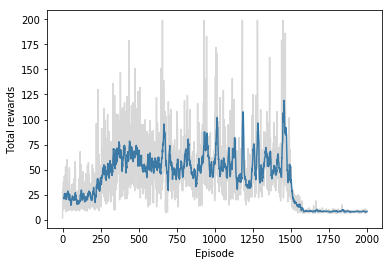

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Fake rewards')

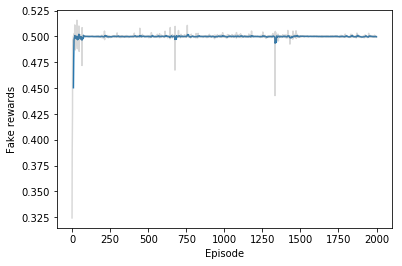

In [24]:
eps, arr = np.array(rewards_fake_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Fake rewards')

Text(0,0.5,'Real rewards')

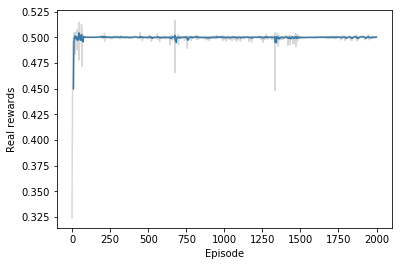

In [25]:
eps, arr = np.array(rewards_real_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Real rewards')

Text(0,0.5,'Q losses')

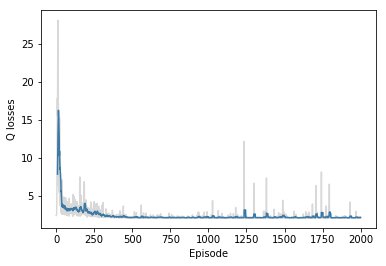

In [26]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

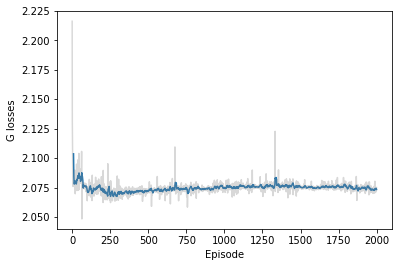

In [27]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

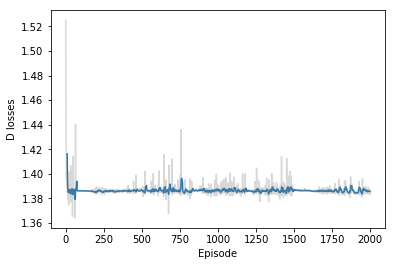

In [28]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [55]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [56]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.